In [12]:

import pandas as pd
import seaborn as sns

from iFEMG_feature import *

In [174]:
# 读取数据，包含三个肌肉信号通道的特征值
data_df = pd.read_csv(r"E:\Data\20230424-单人双次iFEMG肌力等级测试\zpk-1\zpk1_tricps_br.csv", index_col=0, header=[0,1])
data_df.head

<bound method NDFrame.head of     agonist_ch1                                                               \
   subject_name height(cm) weight(kg) gender age    sensor_channel label(kg)   
0    Zou Peikai        190         80      1  26  tricps_br_medial       0.0   
1    Zou Peikai        190         80      1  26  tricps_br_medial       0.0   
2    Zou Peikai        190         80      1  26  tricps_br_medial       0.0   
3    Zou Peikai        190         80      1  26  tricps_br_medial       0.0   
4    Zou Peikai        190         80      1  26  tricps_br_medial       0.0   
5    Zou Peikai        190         80      1  26  tricps_br_medial       0.0   
6    Zou Peikai        190         80      1  26  tricps_br_medial       0.0   
7    Zou Peikai        190         80      1  26  tricps_br_medial       0.0   
8    Zou Peikai        190         80      1  26  tricps_br_medial       0.0   
9    Zou Peikai        190         80      1  26  tricps_br_medial       0.0   
10   Zou P

In [177]:
df2show = data_df['antagonist_ch1']
df2show.head

<bound method NDFrame.head of    subject_name  height(cm)  weight(kg)  gender  age     sensor_channel  \
0    Zou Peikai         190          80       1   26  tricps_br_lateral   
1    Zou Peikai         190          80       1   26  tricps_br_lateral   
2    Zou Peikai         190          80       1   26  tricps_br_lateral   
3    Zou Peikai         190          80       1   26  tricps_br_lateral   
4    Zou Peikai         190          80       1   26  tricps_br_lateral   
5    Zou Peikai         190          80       1   26  tricps_br_lateral   
6    Zou Peikai         190          80       1   26  tricps_br_lateral   
7    Zou Peikai         190          80       1   26  tricps_br_lateral   
8    Zou Peikai         190          80       1   26  tricps_br_lateral   
9    Zou Peikai         190          80       1   26  tricps_br_lateral   
10   Zou Peikai         190          80       1   26  tricps_br_lateral   
11   Zou Peikai         190          80       1   26  tricps_br_latera

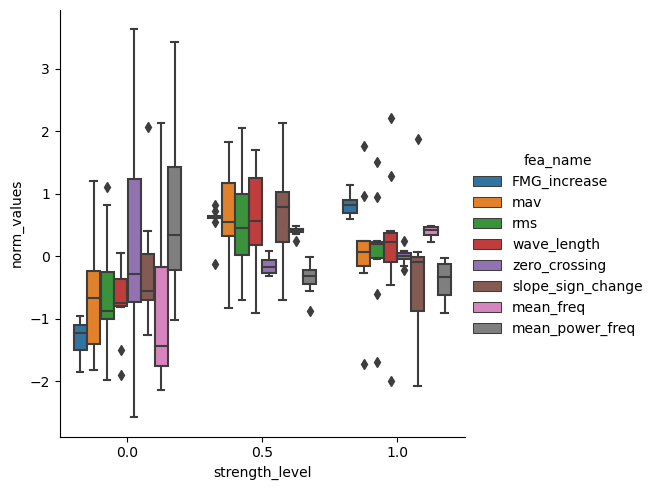

In [178]:
"""
特征可视化
归一化特征值大小----肌力重量
"""
# 需要显示和归一化的特征名称
col_name = ['FMG_increase', 'mav', 'rms', 'wave_length', 'zero_crossing', 'slope_sign_change', 'mean_freq', 'mean_power_freq']
# 调用归一化函数对dataframe进行归一化
sb_fea_norm_df = z_score_norm(df2show, col_name)

# show figure
show_df = pd.DataFrame(columns = ('subject', 'strength_level', 'norm_values', 'fea_name'))

for index, row in sb_fea_norm_df.iterrows():    # go through each row
    for i in col_name:
        show_df = pd.concat([show_df, pd.DataFrame({'subject': [row['subject_name']],
                                                    'strength_level': [row['label(kg)']],
                                                    'norm_values': [row[i]],
                                                    'fea_name': [i]})], axis = 0, ignore_index=True)
# kind = point(两点连线带errbar)/violin(小提琴图)/box(箱线图)
sns.catplot(x = "strength_level",
            y = "norm_values",
            hue = "fea_name",
            data = show_df,
            kind = 'box')